In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import math
import numpy as np
from scipy.signal import detrend
import pywt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[2]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

print(src_path)

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

E:\vatecas\src


In [2]:
initial_time = pd.to_datetime('2023-01-01T12:00:00+00:00')
final_time = pd.Timestamp('2024-01-01T12:00:00+00:00')

In [ ]:
tickers = ["SPY", "NVDA", "TSLA"]  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {
    ticker: pd.read_parquet(path).loc[initial_time:final_time]
    for ticker, path in zip(tickers, data_files)
}
timeline = pd.DatetimeIndex(
    pd.to_datetime(sorted(set().union(*[df.index for df in data.values()])))
)
data = {tk: df.reindex(timeline).ffill() for tk, df in data.items()}
closing_data = {tk: df['adjClose'] for tk, df in data.items()}

<h1>Kalman</h1>

In [4]:
from signal_generator.regression.Kalman_filter import KalmanFilter
from signal_generator.regression.base.oracle_diagnostics import oracle_diagnostics

kalman1 = KalmanFilter(process_noise=1e-1, obs_noise_scale=1e-0)

In [5]:
oracle_diagnostics(oracle=kalman1, data=closing_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)

KalmanOracle is regressing:   0%|          | 1/210 [00:00<00:44,  4.66it/s]

predict in regression: 0.21436980017460883


KalmanOracle is regressing:   1%|          | 2/210 [00:00<00:43,  4.75it/s]

predict in regression: 0.2075984999537468


KalmanOracle is regressing:   1%|▏         | 3/210 [00:00<00:43,  4.77it/s]

predict in regression: 0.20755259995348752


KalmanOracle is regressing:   2%|▏         | 5/210 [00:01<00:45,  4.51it/s]

predict in regression: 0.2517623999156058
predict in regression: 0.212281399872154


KalmanOracle is regressing:   3%|▎         | 7/210 [00:01<00:43,  4.67it/s]

predict in regression: 0.2234930000267923
predict in regression: 0.1970045999623835


KalmanOracle is regressing:   4%|▍         | 8/210 [00:01<00:42,  4.78it/s]

predict in regression: 0.19722119998186827


KalmanOracle is regressing:   5%|▍         | 10/210 [00:02<00:42,  4.72it/s]

predict in regression: 0.22807550011202693
predict in regression: 0.20357869984582067


KalmanOracle is regressing:   6%|▌         | 12/210 [00:02<00:42,  4.70it/s]

predict in regression: 0.2256105998530984
predict in regression: 0.20350529998540878


KalmanOracle is regressing:   6%|▌         | 13/210 [00:02<00:43,  4.53it/s]

predict in regression: 0.23896269989199936


KalmanOracle is regressing:   7%|▋         | 14/210 [00:03<00:43,  4.53it/s]

predict in regression: 0.2207703001331538


KalmanOracle is regressing:   7%|▋         | 15/210 [00:03<00:43,  4.44it/s]

predict in regression: 0.23400090006180108


KalmanOracle is regressing:   8%|▊         | 16/210 [00:03<00:43,  4.46it/s]

predict in regression: 0.22100460017099977


KalmanOracle is regressing:   9%|▊         | 18/210 [00:03<00:41,  4.63it/s]

predict in regression: 0.24541969993151724
predict in regression: 0.1813545001205057


KalmanOracle is regressing:  10%|▉         | 20/210 [00:04<00:37,  5.04it/s]

predict in regression: 0.18719740002416074
predict in regression: 0.1771786999888718


KalmanOracle is regressing:  10%|█         | 22/210 [00:04<00:36,  5.10it/s]

predict in regression: 0.2064676999580115
predict in regression: 0.18413629988208413


KalmanOracle is regressing:  11%|█         | 23/210 [00:04<00:37,  5.05it/s]

predict in regression: 0.20232339994981885


KalmanOracle is regressing:  12%|█▏        | 25/210 [00:05<00:37,  5.00it/s]

predict in regression: 0.20680829999037087
predict in regression: 0.19789740000851452


KalmanOracle is regressing:  12%|█▏        | 26/210 [00:05<00:37,  4.95it/s]

predict in regression: 0.20584350009448826


KalmanOracle is regressing:  13%|█▎        | 27/210 [00:05<00:37,  4.86it/s]

predict in regression: 0.2135926999617368


KalmanOracle is regressing:  14%|█▍        | 29/210 [00:06<00:37,  4.81it/s]

predict in regression: 0.21811429993249476
predict in regression: 0.20357859996147454


KalmanOracle is regressing:  14%|█▍        | 30/210 [00:06<00:38,  4.63it/s]

predict in regression: 0.2334702000953257


KalmanOracle is regressing:  15%|█▌        | 32/210 [00:06<00:37,  4.72it/s]

predict in regression: 0.2229261000175029
predict in regression: 0.19672419992275536


KalmanOracle is regressing:  16%|█▌        | 34/210 [00:07<00:37,  4.75it/s]

predict in regression: 0.24744239985011518
predict in regression: 0.1818963000550866


KalmanOracle is regressing:  17%|█▋        | 36/210 [00:07<00:34,  4.98it/s]

predict in regression: 0.19204130000434816
predict in regression: 0.18967550015076995


KalmanOracle is regressing:  18%|█▊        | 38/210 [00:07<00:33,  5.07it/s]

predict in regression: 0.18324890010990202
predict in regression: 0.1999900999944657


KalmanOracle is regressing:  19%|█▉        | 40/210 [00:08<00:33,  5.11it/s]

predict in regression: 0.2275957001838833
predict in regression: 0.17053370014764369


KalmanOracle is regressing:  20%|██        | 42/210 [00:08<00:34,  4.87it/s]

predict in regression: 0.22592190001159906
predict in regression: 0.20613649999722838


KalmanOracle is regressing:  21%|██        | 44/210 [00:09<00:33,  4.90it/s]

predict in regression: 0.2020254998933524
predict in regression: 0.2023110999725759


KalmanOracle is regressing:  22%|██▏       | 46/210 [00:09<00:33,  4.83it/s]

predict in regression: 0.21384689980186522
predict in regression: 0.20586560014635324


KalmanOracle is regressing:  22%|██▏       | 47/210 [00:09<00:33,  4.82it/s]

predict in regression: 0.20729089993983507


KalmanOracle is regressing:  23%|██▎       | 48/210 [00:10<00:35,  4.61it/s]

predict in regression: 0.23885959992185235


KalmanOracle is regressing:  23%|██▎       | 49/210 [00:10<00:34,  4.63it/s]

predict in regression: 0.21353800012730062


KalmanOracle is regressing:  24%|██▍       | 50/210 [00:10<00:34,  4.67it/s]

predict in regression: 0.21881470014341176


KeyboardInterrupt: 

<h1>Comparison with Synthetic data (pure noise)</h1>

In [6]:
from utils.synthetic import synthetic_data

In [7]:
fake_data = synthetic_data(200, 4, [100, 20, 50, 500], [2, .5, 3, 5])
fake_df = pd.DataFrame(fake_data)

KalmanOracle is regressing:  57%|█████▊    | 92/160 [00:05<00:04, 16.01it/s]e:\vatecas\.conda\env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.312e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
e:\vatecas\.conda\env\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.319e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
Kalman

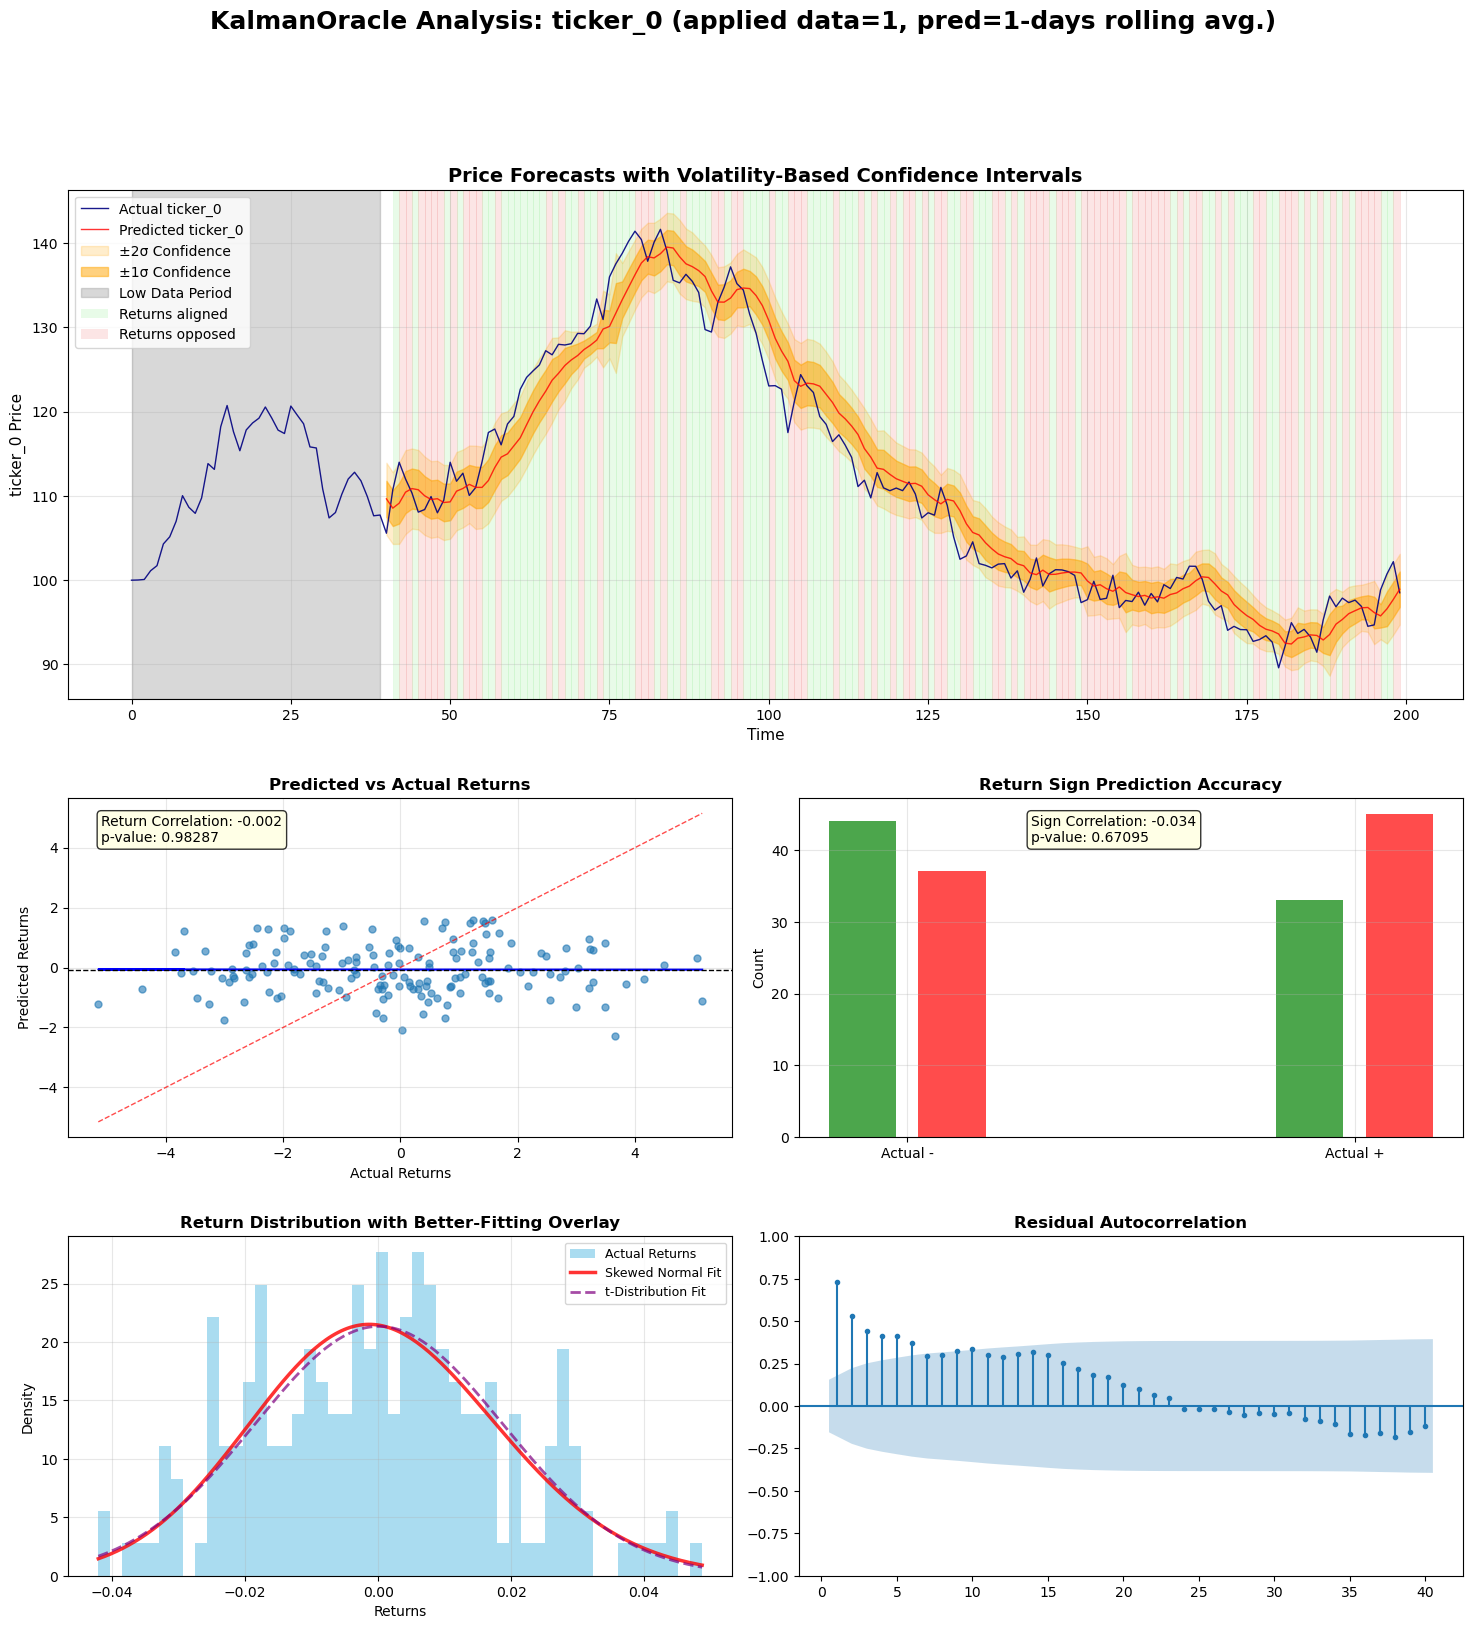

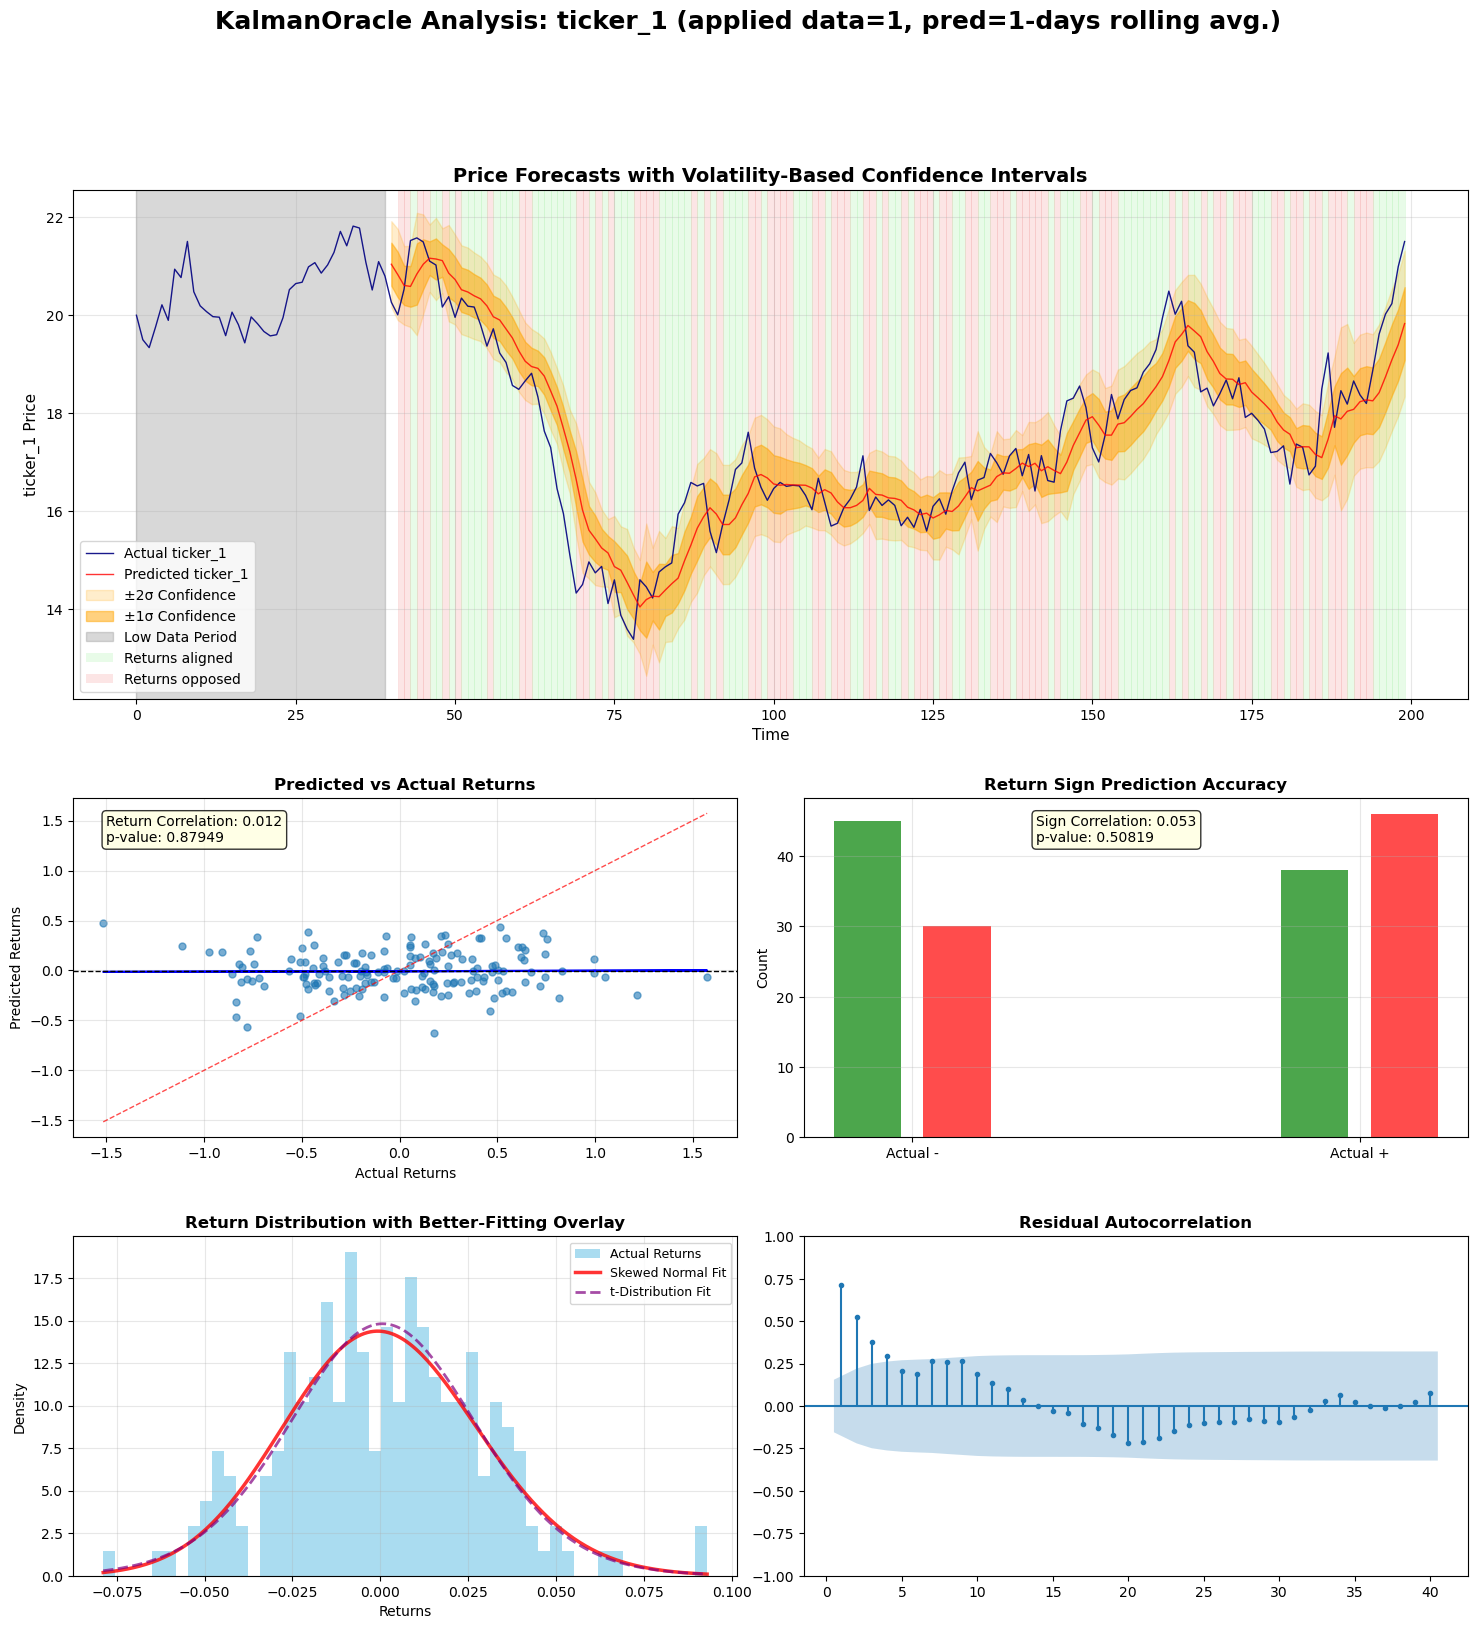

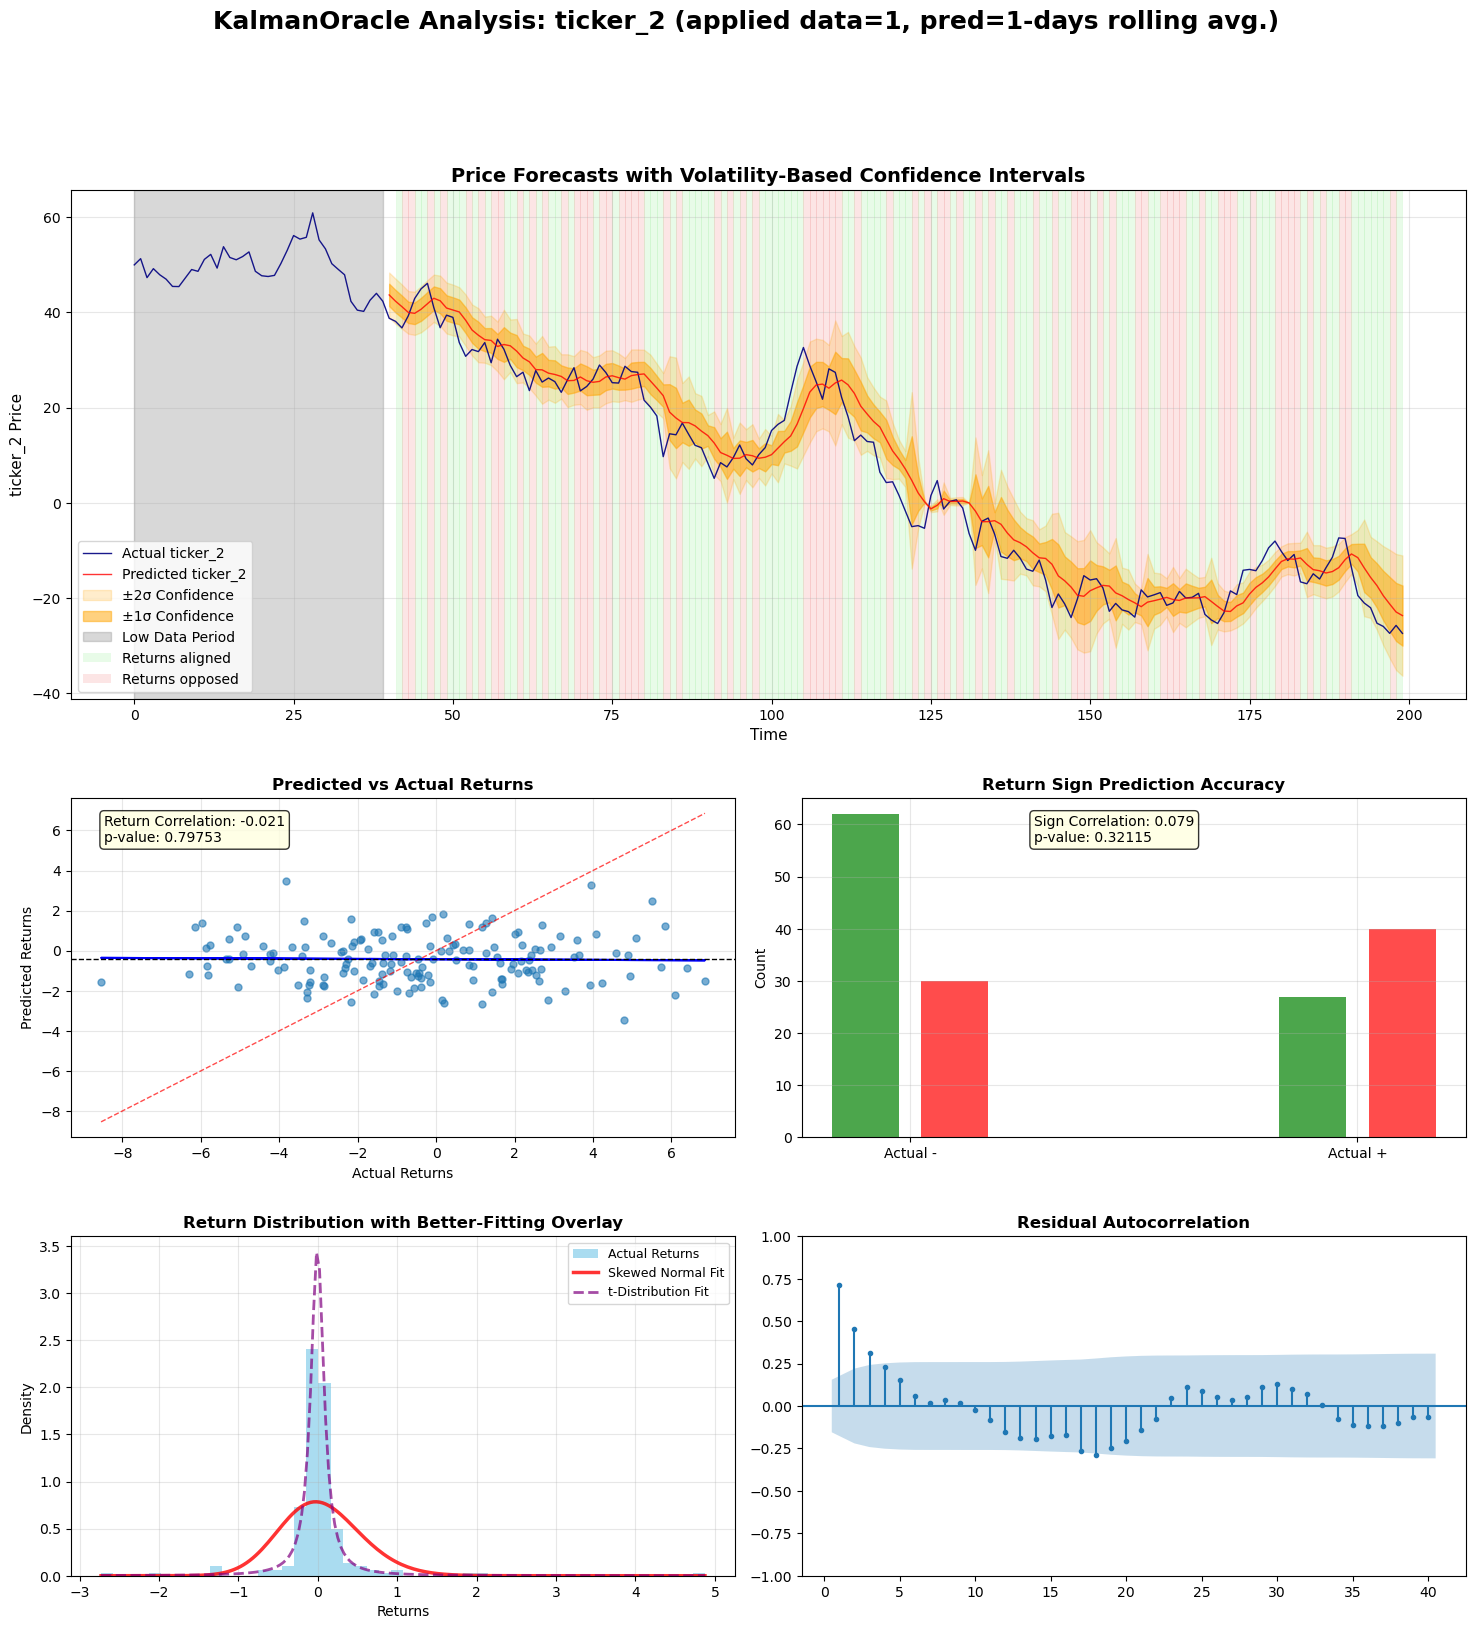

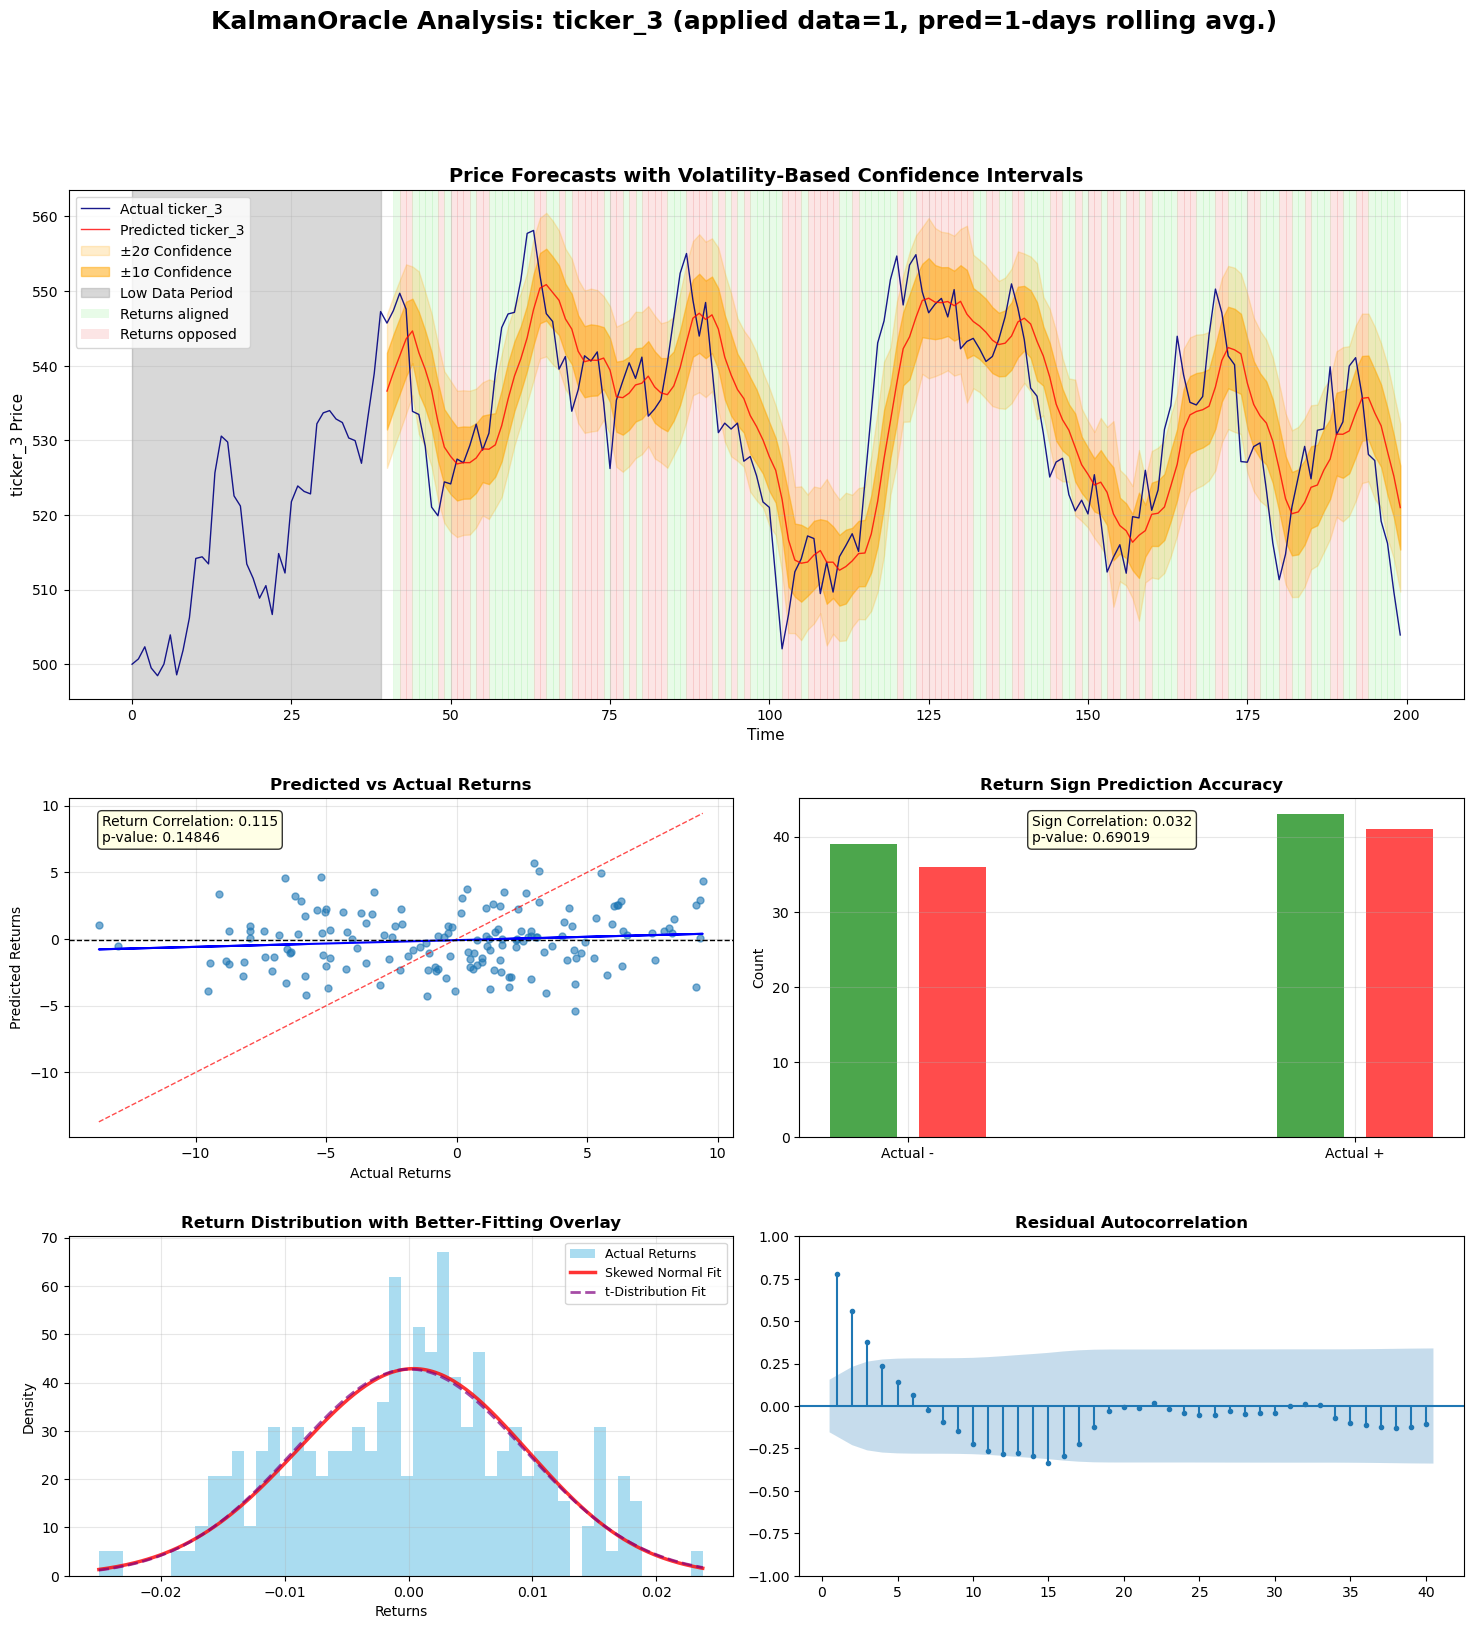

In [8]:
oracle_diagnostics(oracle=kalman1, data=fake_data, regress_window=40, smoothing_window_data=1, smoothing_window_pred=1)